## model

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import glob
from scipy.stats import wasserstein_distance
from scipy.signal import welch
from scipy.stats import entropy

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, Conv2D, LayerNormalization, Dense, ReLU
from tensorflow.nn import relu

from sionna.channel.tr38901 import Antenna, AntennaArray, CDL
from sionna.channel import OFDMChannel
from sionna.mimo import StreamManagement
from sionna.ofdm import ResourceGrid, ResourceGridMapper, LSChannelEstimator, LMMSEEqualizer, RemoveNulledSubcarriers, ResourceGridDemapper
from sionna.utils import BinarySource, ebnodb2no, insert_dims, flatten_last_dims, log10, expand_to_rank
from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder
from sionna.mapping import Mapper, Demapper, Constellation
from sionna.utils.metrics import compute_ber
from sionna.utils import sim_ber, hard_decisions

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0" # 0,1,2,3
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
gpus = tf.config.list_physical_devices('GPU')

print(gpus)

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print("Error loading GPU:", e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

2025-03-15 11:13:00.353136: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-15 11:13:00.399073: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-15 11:13:00.399100: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-15 11:13:00.400218: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-15 11:13:00.408279: I tensorflow/core/platform/cpu_feature_guar

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
class ModifiedResourceGridMapper(Layer):
    def __init__(self, resource_grid, dtype=tf.complex64, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        self._resource_grid = resource_grid
        self._rg_type = self._resource_grid.build_type_grid()
        self._pilot_ind = tf.where(self._rg_type == 1)  # Indices for pilots

    def extract_pilots(self, input_rg):
        input_rg = tf.squeeze(input_rg, axis=1)
        
        pilot_grid = tf.zeros_like(input_rg)
        pilot_values = tf.gather_nd(input_rg, self._pilot_ind)
        pilot_grid = tf.tensor_scatter_nd_update(pilot_grid, self._pilot_ind, pilot_values)
        
        pilot_grid = tf.expand_dims(pilot_grid, axis=1)
        
        return pilot_grid

    def replace(self, inputs):
        # Unpack the generated and real resource grids
        generated_y_rg, real_y_rg = inputs  # (batch, 1, 2, ofdm, subcar)

        generated_y_rg = tf.squeeze(generated_y_rg, axis=1)
        real_y_rg = tf.squeeze(real_y_rg, axis=1)

        # Extract the pilots from the real resource grid
        real_pilots = tf.gather_nd(real_y_rg, self._pilot_ind)

        # Replace the pilots in the generated resource grid with the real pilots
        updated_y_rg = tf.tensor_scatter_nd_update(generated_y_rg, self._pilot_ind, real_pilots)
        updated_y_rg = tf.expand_dims(updated_y_rg, axis=1)  # Restore dimensions

        return updated_y_rg

In [4]:
# ## Channel configuration
carrier_frequency = 3.5e9 # Hz
delay_spread = 100e-9 # s
cdl_model = "C" # CDL model to use
speed = 10.0 # Speed for evaluation and training [m/s]
# SNR range for evaluation and training [dB]
ebno_db_min = 0.0
ebno_db_max = 10.0

############################################
## OFDM waveform configuration
subcarrier_spacing = 30e3 # Hz
fft_size = 128 # Number of subcarriers forming the resource grid, including the null-subcarrier and the guard bands
num_ofdm_symbols = 14 # Number of OFDM symbols forming the resource grid
dc_null = True # Null the DC subcarrier
num_guard_carriers = [5, 6] # Number of guard carriers on each side
pilot_pattern = "kronecker" # Pilot pattern
pilot_ofdm_symbol_indices = [2, 11] # Index of OFDM symbols carrying pilots
cyclic_prefix_length = 0 # Simulation in frequency domain. This is useless

############################################
## Modulation and coding configuration
num_bits_per_symbol = 6 # 64-QAM
coderate = 0.5 # Coderate for LDPC code
noise_dim = 100

############################################
## Neural receiver configuration
num_conv_channels = 128 # Number of convolutional channels for the convolutional layers forming the neural receiver

############################################
## Training configuration
num_training_iterations = 50000 # Number of training iterations
training_batch_size = 128 # Training batch size
model_weights_path_standard = "neural_receiver_weights_standard" # Location to save the neural receiver weights once training is done
model_weights_path_trained = "neural_receiver_weights_trained"

############################################
## Evaluation configuration
results_filename = "neural_receiver_results" # Location to save the results

stream_manager = StreamManagement(np.array([[1]]), # Receiver-transmitter association matrix
                                  1)               # One stream per transmitter

resource_grid = ResourceGrid(num_ofdm_symbols = num_ofdm_symbols,
                             fft_size = fft_size,
                             subcarrier_spacing = subcarrier_spacing,
                             num_tx = 1,
                             num_streams_per_tx = 1,
                             cyclic_prefix_length = cyclic_prefix_length,
                             dc_null = dc_null,
                             pilot_pattern = pilot_pattern,
                             pilot_ofdm_symbol_indices = pilot_ofdm_symbol_indices,
                             num_guard_carriers = num_guard_carriers)

n = int(resource_grid.num_data_symbols*num_bits_per_symbol)
k = int(n*coderate)

ut_antenna = Antenna(polarization="single",
                     polarization_type="V",
                     antenna_pattern="38.901",
                     carrier_frequency=carrier_frequency)

bs_array = AntennaArray(num_rows=1,
                        num_cols=1,
                        polarization="single", # dual
                        polarization_type="V", # VH
                        antenna_pattern="38.901",
                        carrier_frequency=carrier_frequency)

In [5]:
class ResidualBlock(Layer):
    def __init__(self, name=None, **kwargs):
        super(ResidualBlock, self).__init__(name=name, **kwargs)
    
        # Layer normalization is done over the last three dimensions: time, frequency, conv 'channels'
        self._layer_norm_1 = LayerNormalization(axis=(-1, -2, -3))
        self._conv_1 = Conv2D(filters=num_conv_channels,
                              kernel_size=[3,3],
                              padding='same',
                              activation=None)
        # Layer normalization is done over the last three dimensions: time, frequency, conv 'channels'
        self._layer_norm_2 = LayerNormalization(axis=(-1, -2, -3))
        self._conv_2 = Conv2D(filters=num_conv_channels,
                              kernel_size=[3,3],
                              padding='same',
                              activation=None)

    def call(self, inputs):
        z = self._layer_norm_1(inputs)
        z = relu(z)
        z = self._conv_1(z)
        z = self._layer_norm_2(z)
        z = relu(z)
        z = self._conv_2(z) # [batch size, num time samples, num subcarriers, num_channels]
        # Skip connection
        z = z + inputs

        return z

class NeuralReceiver(Model):
    def __init__(self, **kwargs):
        super(NeuralReceiver, self).__init__(**kwargs)
        self.receiver = self.build_receiver()
    
    def build_receiver(self):
        self._input_conv = Conv2D(filters=num_conv_channels,
                                  kernel_size=[3,3],
                                  padding='same',
                                  activation=None,
                                 name="neural_receiver_input_conv")
        self._output_conv = Conv2D(filters=num_bits_per_symbol,
                                   kernel_size=[3,3],
                                   padding='same',
                                   activation=None,
                                  name="neural_receiver_output_conv")

        inputs = tf.keras.Input(shape=(14, 128, 3))
        # Input conv
        z = self._input_conv(inputs)
        # Residual blocks
        z = ResidualBlock(name="neural_receiver_residual_block_1")(z)
        z = ResidualBlock(name="neural_receiver_residual_block_2")(z)
        z = ResidualBlock(name="neural_receiver_residual_block_3")(z)
        z = ResidualBlock(name="neural_receiver_residual_block_4")(z)
        # Output conv
        z = self._output_conv(z)
        
        return tf.keras.Model(inputs=inputs, outputs=z, name="Neural_receiver")

    def call(self, inputs):
        y, no = inputs

        # Feeding the noise power in log10 scale helps with the performance
        no = log10(no)

        # Stacking the real and imaginary components of the different antennas along the 'channel' dimension
        y = tf.transpose(y, [0, 2, 3, 1]) # Putting antenna dimension last
        no = insert_dims(no, 3, 1)
        no = tf.tile(no, [1, y.shape[1], y.shape[2], 1])
        # z : [batch size, num ofdm symbols, num subcarriers, 2*num rx antenna + 1]
        z = tf.concat([tf.math.real(y),
                       tf.math.imag(y),
                       no], axis=-1)

        z = self.receiver(z)

        return z

In [6]:
class GANGenerator(tf.keras.Model):
    def __init__(self, **kwargs):
        super(GANGenerator, self).__init__(**kwargs)
        self.generator = self.build_generator()

    def build_generator(self):
        """Builds the generator model."""
        x_real_input = tf.keras.layers.Input(shape=(14,128,2))  # (batch,14,128,2)
        noise_input = tf.keras.layers.Input(shape=(14,128,noise_dim)) 
        h_input = tf.keras.layers.Input(shape=(14,128,2))  # (batch,14,128,2)
        
        x = tf.keras.layers.Concatenate()([x_real_input, noise_input, h_input])

        x = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', use_bias=False)(x)
        x = tf.keras.layers.ReLU()(x)
        x = tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', use_bias=False)(x)
        x = tf.keras.layers.ReLU()(x)
        x = tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', use_bias=False)(x)
        x = tf.keras.layers.ReLU()(x)
        x = tf.keras.layers.Conv2D(filters=2, kernel_size=(3, 3), padding='same', use_bias=False)(x)
        
        return  tf.keras.Model(inputs=[x_real_input, noise_input, h_input], outputs=x, name="GANChannel_Generator")
    
    def call(self, z, x, h):
        x = tf.squeeze(x, axis=[1,2])
        
        x_real, x_imag = tf.math.real(x), tf.math.imag(x) # [batch,14,128]
        x_flat = tf.stack([x_real, x_imag], axis=-1) #  [batch,14,128,2]

        h = tf.squeeze(h, axis=[1,2,3,4])
        h_real, h_imag = tf.math.real(h), tf.math.imag(h) # [batch,14,128]
        h_flat = tf.stack([h_real, h_imag], axis=-1) #  [batch,14,128,2]
        
        y = self.generator([x_flat, z, h_flat]) # [batch,14,128,2]

        y_r, y_i = y[:,:,:,0], y[:,:,:,1] 
        y_complex = tf.complex(y_r, y_i)
        
        y_complex = tf.expand_dims(y_complex, axis=1)
        y_complex = tf.expand_dims(y_complex, axis=1)
        
        return y_complex

In [7]:
class E2ESystem(Model):
    def __init__(self, training=False):
        super().__init__()
        self._training = training
        self.x_rg = None
        self.y_gen = None
        self.y_real = None
        self.h_freq = None
        self.prior_constellation = None
        self.post_constellation = None
        # self.ls_estimator = LSChannelEstimator(resource_grid, interpolation_type="nn")

        ######################################
        ## Transmitter
        self._binary_source = BinarySource()
        # To reduce the computational complexity of training, the outer code is not used when training,
        # as it is not required
        if not training:
            self._encoder = LDPC5GEncoder(k, n)
            
        # Trainable constellation
        constellation = Constellation("qam", num_bits_per_symbol, trainable=True)
        self.constellation = constellation
        self._mapper = Mapper(constellation=constellation)
        self._rg_mapper = ResourceGridMapper(resource_grid)         

        ######################################
        ## Channel
        # A 3GPP CDL channel model is used
        cdl = CDL(cdl_model, delay_spread, carrier_frequency,
                  ut_antenna, bs_array, "uplink", min_speed=speed)
        self._real_channel = OFDMChannel(cdl, resource_grid, normalize_channel=True, return_channel=True)

        self._gan_channel = GANGenerator()

        ######################################
        ## Receiver
        self._neural_receiver = NeuralReceiver()
        self._rg_demapper = ResourceGridDemapper(resource_grid, stream_manager) # Used to extract data-carrying resource elements
            
        # To reduce the computational complexity of training, the outer code is not used when training,
        # as it is not required
        if not training:
            self._decoder = LDPC5GDecoder(self._encoder, hard_out=True)
    
    @tf.function
    def call(self, batch_size, ebno_db, use_gan_channel=False):
        
        # If `ebno_db` is a scalar, a tensor with shape [batch size] is created as it is what is expected by some layers
        if len(ebno_db.shape) == 0:
            ebno_db = tf.fill([batch_size], ebno_db)

        ######################################
        ## Transmitter
        no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate)
        
        # Outer coding is only performed if not training
        if self._training:
            c = self._binary_source([batch_size, 1, 1, n])
        else:
            b = self._binary_source([batch_size, 1, 1, k])
            c = self._encoder(b)
        
        # c = self._binary_source([batch_size, 1, 1, n]) # for uncoded simulation
        
        # Modulation
        self.prior_constellation = c
        x = self._mapper(c)
        self.post_constellation = x
        
        x_rg = self._rg_mapper(x)

        self.x_rg = x_rg

        ######################################
        ## Channel
        # A batch of new channel realizations is sampled and applied at every inference
        no_ = expand_to_rank(no, tf.rank(x_rg))
        y,h = self._real_channel([x_rg, no_])

        self.y_real = y

        ### ----------------- GAN channel
        if use_gan_channel: 
            out_list = []
            z = tf.random.normal([batch_size, 14, 128, noise_dim])        
            y = self._gan_channel(z, x_rg, h)
            self.h_freq = h
            self.y_gen = y
            
        ######################################
        ## Receiver    
        # The neural receover computes LLRs from the frequency domain received symbols and N0
        y = tf.squeeze(y, axis=1)
        llr = self._neural_receiver([y, no])
        llr = insert_dims(llr, 2, 1) # Reshape the input to fit what the resource grid demapper is expected
        llr = self._rg_demapper(llr) # Extract data-carrying resource elements. The other LLrs are discarded
        llr = tf.reshape(llr, [batch_size, 1, 1, n]) # Reshape the LLRs to fit what the outer decoder is expected

        # Outer coding is not needed if the information rate is returned
        if self._training:
            # Compute and return BMD rate (in bit), which is known to be an achievable
            # information rate for BICM systems. Training aims at maximizing the BMD rate
            bce = tf.nn.sigmoid_cross_entropy_with_logits(c, llr)
            bce = tf.reduce_mean(bce)
            rate = tf.constant(1.0, tf.float32) - bce/tf.math.log(2.)
            if use_gan_channel:
                return rate, self.x_rg, self.y_gen, self.y_real, self.h_freq
            else:
                return rate
        else:
            # Outer decoding
            b_hat = self._decoder(llr)
            return b,b_hat
            # probabilities = tf.math.sigmoid(llr)
            # b_hat = tf.cast(probabilities > 0.5, dtype=tf.float32) # 0.5-1 is False=bit 0; 0-0.5 is True=bit 1 
            # return c,b_hat # Ground truth and reconstructed information bits returned for BER/BLER computation

In [8]:
## Transmitter
binary_source = BinarySource()
# mapper = Mapper("qam", num_bits_per_symbol)
# rg_mapper = ResourceGridMapper(resource_grid)

constellation = Constellation("qam", num_bits_per_symbol, trainable=True)
mapper = Mapper(constellation=constellation)
rg_mapper = ResourceGridMapper(resource_grid)

## Channel
cdl = CDL(cdl_model, delay_spread, carrier_frequency,
          ut_antenna, bs_array, "uplink", min_speed=speed)
channel = OFDMChannel(cdl, resource_grid, normalize_channel=True, return_channel=True)

## Receiver
neural_receiver = NeuralReceiver()
rg_demapper = ResourceGridDemapper(resource_grid, stream_manager) # Used to extract data-carrying resource elements

# resource grid helper
rg_util = ModifiedResourceGridMapper(resource_grid)

## Final visual

In [ ]:
plt.figure(figsize=(10,6))

with open('neural_receiver_results_50000_standardAndTrained', 'rb') as file:
        ebno_dbs, BLER_st, BER_st = pickle.load(file)
BER_st = BER
BLER_ = BLER
with open('neural_receiver_results_50000_gan', 'rb') as file:
        ebno_dbs, BLER_g, BER_g = pickle.load(file)
BER_g = BER
BLER_g = BLER

plt.subplot(2, 1, 1)
plt.semilogy(ebno_dbs, BER_st['neural-receiver-standard'], 's-.', c=f'C1', label=f'E2E without GAN (QAM mapper)')
plt.semilogy(ebno_dbs, BER_st['neural-receiver-trained'], 's-.', c=f'C2', label=f'E2E without GAN (Neural mapper)')
plt.semilogy(ebno_dbs, BER_g['neural-receiver-gan-trained'], 's-.', c=f'C3', label=f'E2E GAN')

plt.xlabel(r"$E_b/N_0$ (dB)")
plt.ylabel("BER")
plt.grid(which="both")
plt.ylim((1e-4, 1.0))
plt.legend()
plt.tight_layout()

plt.subplot(2, 2, 2)
plt.semilogy(ebno_dbs, BLER_st['neural-receiver-standard'], 's-.', c=f'C1', label=f'E2E without GAN (QAM mapper)')
plt.semilogy(ebno_dbs, BLER_st['neural-receiver-trained'], 's-.', c=f'C2', label=f'E2E without GAN (Neural mapper)')
plt.semilogy(ebno_dbs, BLER_g['neural-receiver-gan-trained'], 's-.', c=f'C3', label=f'E2E GAN')

plt.xlabel(r"$E_b/N_0$ (dB)")
plt.ylabel("BLER")
plt.grid(which="both")
plt.ylim((1e-4, 1.0))
plt.legend()
plt.tight_layout()

## Plot

In [9]:
def compute_psd_line(y):
    y = y.reshape(128, 14, 128)
    print(y.shape)
    fft_result = tf.signal.fft(y)  # Shape: [batch, 14, 128]
    power_db = 20 * tf.math.log(tf.abs(fft_result) + 1e-10) / tf.math.log(10.0)  # Convert to dB
    power_db_shifted = tf.signal.fftshift(power_db, axes=[-1])  # Shape: [batch, 14, 128]
    return power_db_shifted.mean(axis=1)  # Shape: [batch, 128]

def plot_psd_line(psd_real, psd_fake):
    # Convert to NumPy and average over batch
    psd_real_np = psd_real.mean(axis=0).numpy() # Shape: [128]
    psd_fake_np = psd_fake.mean(axis=0).numpy()  # Shape: [128]
    
    # Frequency axis (normalized subcarriers)
    freq_axis = np.linspace(-0.5, 0.5, psd_real_np.shape[-1])  # Normalized frequencies
    # Plot
    plt.figure(figsize=(18, 2))
    plt.plot(freq_axis, psd_real_np, label="Real PSD", linewidth=2)
    plt.plot(freq_axis, psd_fake_np, label="Generated PSD", linewidth=2)
    plt.xlabel("Normalized Frequency")
    plt.ylabel("PSD (dB)")
    plt.title("Power Spectral Density of OFDM Signal")
    plt.legend()
    plt.grid()
    plt.show()

In [10]:
def compute_phase_mismatch(real_y, generated_y):
    # Compute phase angles
    phase_real = tf.math.angle(real_y)  # Phase of real samples
    phase_fake = tf.math.angle(generated_y)  # Phase of generated samples
    # Compute absolute phase difference
    phase_diff = tf.abs(phase_real - phase_fake)  # Element-wise |phase_real - phase_fake|
    # Wrap phase difference to [-π, π] to avoid large discontinuities
    phase_diff = tf.where(phase_diff > np.pi, 2 * np.pi - phase_diff, phase_diff)
    # Compute mean phase error over batch and OFDM symbols
    phase_error = tf.reduce_mean(phase_diff)
    
    return phase_error.numpy()

def plot_phase_distribution(real_y, generated_y):
    phase_real = tf.math.angle(real_y).numpy().flatten()
    phase_fake = tf.math.angle(generated_y).numpy().flatten()

    plt.figure(figsize=(8, 3))
    plt.hist(phase_real, bins=50, alpha=0.5, label="Real Phase", density=True)
    plt.hist(phase_fake, bins=50, alpha=0.5, label="Generated Phase", density=True)
    plt.xlabel("Phase (radians)")
    plt.ylabel("Density")
    plt.title("Phase Distribution of Real and Generated Signals")
    plt.legend()
    plt.grid()
    plt.show()

In [11]:
def plot_amplitude_distribution(real_y, generated_y, bins=50):
    # Compute amplitude (magnitude) of complex signals
    real_amplitude = np.abs(real_y).flatten()
    gen_amplitude = np.abs(generated_y).flatten()

    # Plot histograms
    plt.figure(figsize=(8, 3))
    plt.hist(real_amplitude, bins=bins, density=True, alpha=0.5, color='blue', label='Real')
    plt.hist(gen_amplitude, bins=bins, density=True, alpha=0.5, color='red', label='Generated')

    plt.xlabel("Amplitude")
    plt.ylabel("Density")
    plt.title("Amplitude Distribution of Real vs. Generated Signals")
    plt.legend()
    plt.grid()
    plt.show()

(128, 14, 128)
(128, 14, 128)


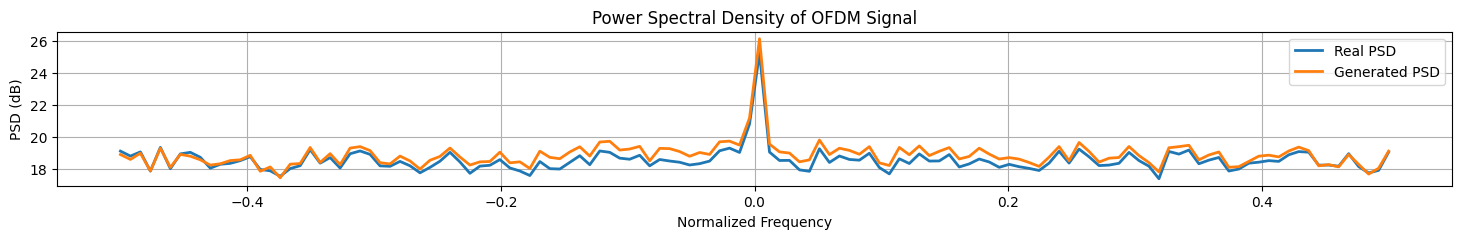

Mean Absolute Phase Error: 0.4867 radians


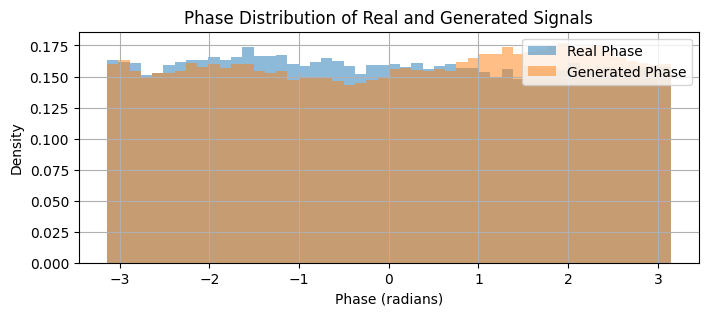

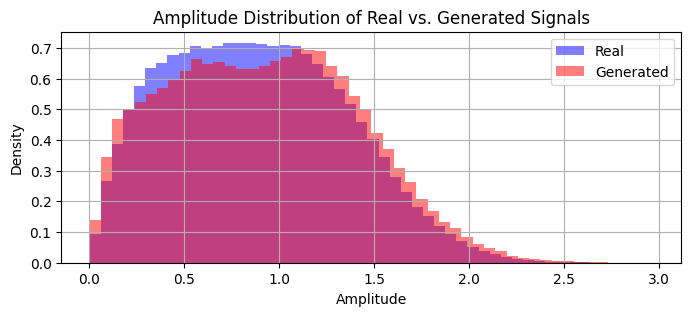

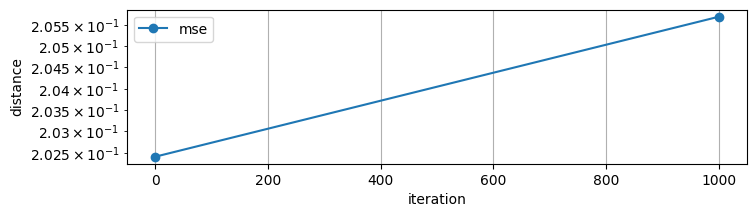

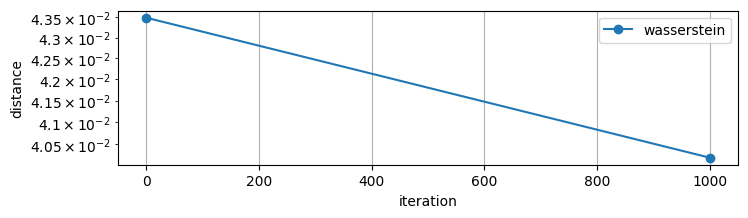

In [14]:
def load_complex_data(filename):
    with open(filename, 'r') as file:
        return np.array([complex(line.strip()) for line in file])

output_dir = 'y_output'
iterations = []
mse_values = []
was_values = []

for filename in sorted(os.listdir(output_dir)):
    if filename.startswith("tx_generated_y_") and filename.endswith(".txt"):
        iteration = int(filename.split('_')[-1].split('.')[0])

#         if iteration >= 5000
        generated_y_file = os.path.join(output_dir, f"tx_generated_y_{iteration}.txt")
        real_y_file = os.path.join(output_dir, f"tx_real_y_{iteration}.txt")

        generated_y = load_complex_data(generated_y_file)
        real_y = load_complex_data(real_y_file)

        if len(generated_y) != len(real_y):
            print(f"Mismatch at iteration {iteration}: {len(generated_y)} vs {len(real_y)}")
            continue

        wasserstein = wasserstein_distance(np.abs(real_y), np.abs(generated_y))

        squared_diff = np.square(np.abs(real_y - generated_y))  # |y_real - y_fake|^2
        mse = np.mean(squared_diff)

        iterations.append(iteration)
        mse_values.append(mse)
        was_values.append(wasserstein)
        # kl_values.append(kl_div)

        if iteration == 1000:
            psd_real_line = compute_psd_line(real_y) 
            psd_generated_line = compute_psd_line(generated_y)
            plot_psd_line(psd_real_line, psd_generated_line)

            # tf.experimental.numpy.experimental_enable_numpy_behavior()
            # phase_error = compute_phase_mismatch(real_y, generated_y) # >>0.5 is bad
            # print(f"Mean Absolute Phase Error: {phase_error:.4f} radians")
            plot_phase_distribution(real_y, generated_y)

            plot_amplitude_distribution(real_y, generated_y)

sorted_indices = np.argsort(iterations)
iterations = np.array(iterations)[sorted_indices]
mse_values = np.array(mse_values)[sorted_indices]
was_values = np.array(was_values)[sorted_indices]

plt.figure(figsize=(8, 2))
plt.plot(iterations, mse_values, marker='o', label='mse')
plt.xlabel('iteration')
plt.ylabel('distance')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 2))
plt.plot(iterations, was_values, marker='o', label='wasserstein')
plt.xlabel('iteration')
plt.ylabel('distance')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def load_complex_data(filename):
    with open(filename, 'r') as file:
        return np.array([complex(line.strip()) for line in file])

train_generated_y = load_complex_data("y_output/train_generated_y_500.txt")
train_real_y = load_complex_data("y_output/train_real_y_500.txt")
generated_y_tx = load_complex_data("y_output/tx_generated_y_500.txt")
real_y_tx = load_complex_data("y_output/tx_real_y_500.txt")

half_size = len(generated_y_tx) // 2
rx1_train_generated_y = train_generated_y[:half_size]
rx2_train_generated_y = train_generated_y[half_size:]
rx1_train_real_y = train_real_y[:half_size]
rx2_train_real_y = train_real_y[half_size:]

rx1_generated_y_tx = generated_y_tx[:half_size]
rx2_generated_y_tx = generated_y_tx[half_size:]
rx1_real_y_tx = real_y_tx[:half_size]
rx2_real_y_tx = real_y_tx[half_size:]

plt.figure(figsize=(16, 8))

plt.subplot(2, 4, 1)
plt.scatter(rx1_train_generated_y.real, rx1_train_generated_y.imag, label="Training Generated y", alpha=0.5)
plt.title("RX1-G Training (batch_size=128)")
plt.grid()

plt.subplot(2, 4, 2)
plt.scatter(rx1_train_real_y.real, rx1_train_real_y.imag, label="Training Real y", alpha=0.5)
plt.title("RX1-Real Training")
plt.grid()

plt.subplot(2, 4, 3)
plt.scatter(rx1_generated_y_tx.real, rx1_generated_y_tx.imag, label="Generated y", alpha=0.5)
plt.title("RX1-G(Tx) (batch_size=128)")
plt.grid()

plt.subplot(2, 4, 4)
plt.scatter(rx1_real_y_tx.real, rx1_real_y_tx.imag, label="Real y", alpha=0.5)
plt.title("RX1-Real(Tx)")
plt.grid()

plt.subplot(2, 4, 5)
plt.scatter(rx2_train_generated_y.real, rx2_train_generated_y.imag, label="Training Generated y", alpha=0.5)
plt.title("RX2-G Training (batch_size=128)")
plt.grid()

plt.subplot(2, 4, 6)
plt.scatter(rx2_train_real_y.real, rx2_train_real_y.imag, label="Training Real y", alpha=0.5)
plt.title("RX1-Real Training")
plt.grid()

plt.subplot(2, 4, 7)
plt.scatter(rx2_generated_y_tx.real, rx2_generated_y_tx.imag, label="Generated y", alpha=0.5)
plt.title("RX2-G(Tx) (batch_size=128)")
plt.grid()

plt.subplot(2, 4, 8)
plt.scatter(rx2_real_y_tx.real, rx2_real_y_tx.imag, label="Real y", alpha=0.5)
plt.title("RX2-Real(Tx)")
plt.grid()

plt.tight_layout()
plt.show()

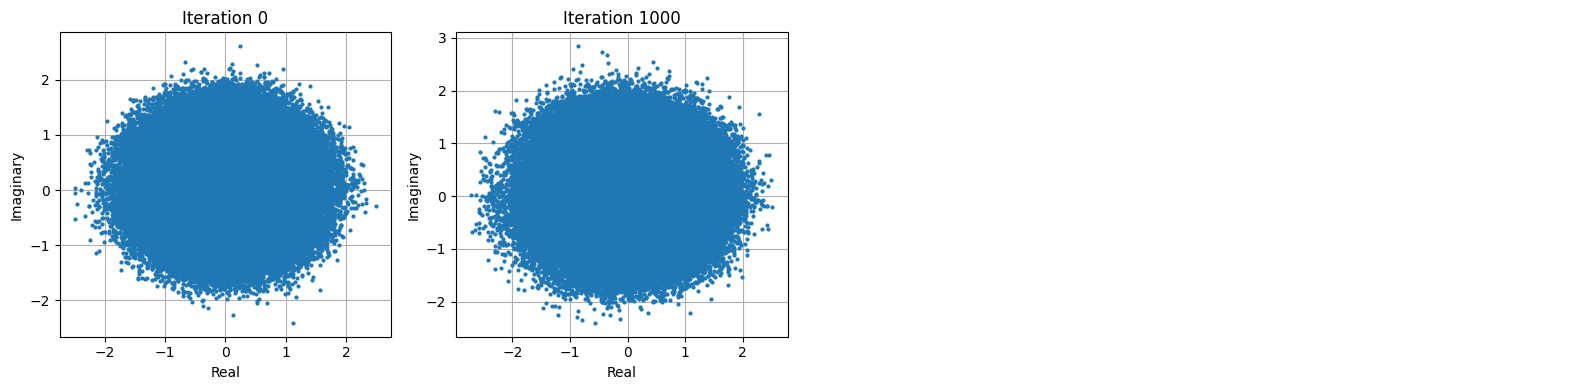

In [16]:
def load_complex_data(filename):
    """Load complex data from a text file."""
    with open(filename, 'r') as file:
        return np.array([complex(line.strip()) for line in file])

file_pattern = "y_output/tx_generated_y_*.txt"
files = sorted(glob.glob(file_pattern), key=lambda x: int(os.path.basename(x).split('_')[-1].split('.')[0]))
files = [f for f in files if int(os.path.basename(f).split('_')[-1].split('.')[0]) % 1000 == 0] 

data = []
iterations = []

for file in files:
    iteration = int(os.path.basename(file).split('_')[-1].split('.')[0])
    iterations.append(iteration)
    d = load_complex_data(file)
    d = d[:len(d)//2]
    data.append(d)

# Plotting
num_files = len(data)
rows = (num_files + 3) // 4  # Adjust the number of columns as needed
cols = 4

fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 4))
axes = axes.flatten()

for i, (iteration, y_data) in enumerate(zip(iterations, data)):
    ax = axes[i]
    ax.plot(y_data.real, y_data.imag, 'o', markersize=2)
    ax.set_title(f"Iteration {iteration}")
    ax.set_xlabel("Real")
    ax.set_ylabel("Imaginary")
    ax.grid(True)

for ax in axes[num_files:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

## Constellation

In [ ]:
def load_weights(model, model_weights_path):
    model(training_batch_size, tf.constant(10.0, tf.float32),  use_gan_channel=True)
    with open(model_weights_path, 'rb') as f:
        weights = pickle.load(f)
    model.set_weights(weights)
    
model = E2ESystem(training=True)
load_weights(model, 'weights_trained/model_weights_0.pkl')

# fig = model.constellation.show()
constellation = model.constellation
figsize=(4,4)
maxval = np.max(np.abs(constellation.points))*1.05
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
plt.xlim(-maxval, maxval)
plt.ylim(-maxval, maxval)
plt.scatter(np.real(constellation.points), np.imag(constellation.points))
ax.set_aspect("equal", adjustable="box")
plt.grid(True, which="both", axis="both")
plt.title("Trained mapper")
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
# for j, p in enumerate(constellation.points):
#     plt.annotate(
#         np.binary_repr(j, num_bits_per_symbol),
#         (np.real(p), np.imag(p))
#     )

2025-03-15 11:14:07.266310: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2025-03-15 11:14:07.376128: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [ ]:
tf.config.run_functions_eagerly(True) 
model = E2ESystem(training=True)
model(1, tf.constant(10.0, tf.float32), use_gan_channel=False)
with open('weights_trained/model_weights_12000.pkl', 'rb') as f:
    weights = pickle.load(f)
model.set_weights(weights)

prior_constellation = np.squeeze(model.prior_constellation.numpy())
post_constellation = np.squeeze(model.post_constellation.numpy())

constellation = Constellation("qam", num_bits_per_symbol, trainable=True)
x = Mapper(constellation=constellation)(model.prior_constellation)

# Plot prior constellation
figsize = (4, 4)
fig = plt.figure(figsize=figsize)
maxval = np.max(np.abs(prior_constellation)) * 1.05
ax = fig.add_subplot(111)
plt.xlim(-maxval, maxval)
plt.ylim(-maxval, maxval)
plt.scatter(np.real(prior_constellation), np.imag(prior_constellation))
ax.set_aspect("equal", adjustable="box")
plt.grid(True, which="both", axis="both")
# for j, p in enumerate(prior_constellation):
#     plt.annotate(np.binary_repr(j, num_bits_per_symbol), (np.real(p), np.imag(p)))

# Plot original mapper
figsize = (4, 4)
fig = plt.figure(figsize=figsize)
maxval = np.max(np.abs(x)) * 1.05
ax = fig.add_subplot(111)
plt.xlim(-maxval, maxval)
plt.ylim(-maxval, maxval)
plt.scatter(np.real(x), np.imag(x))
ax.set_aspect("equal", adjustable="box")
plt.grid(True, which="both", axis="both")
# for j, p in enumerate(prior_constellation):
#     plt.annotate(np.binary_repr(j, num_bits_per_symbol), (np.real(p), np.imag(p)))

# Plot post constellation
fig = plt.figure(figsize=figsize)
# maxval = np.max(np.abs(prior_constellation)) * 1.05
ax = fig.add_subplot(111)
# plt.xlim(-maxval, maxval)
# plt.ylim(-maxval, maxval)
plt.scatter(np.real(post_constellation), np.imag(post_constellation))
ax.set_aspect("equal", adjustable="box")
plt.grid(True, which="both", axis="both")
# for j, p in enumerate(post_constellation):
#     plt.annotate(np.binary_repr(j, num_bits_per_symbol), (np.real(p), np.imag(p)))

plt.show()

In [ ]:
import re

file_path = "tmp_output.txt"
pattern = r"Iteration \d+/\d+, Eb/No: [-+]?\d+\.\d+, gp: [-+]?\d+\.\d+(?:e[-+]?\d+)?,  d loss: [-+]?\d+\.\d+, g loss: [-+]?\d+\.\d+"
pattern2 = r"Iteration \d+/\d+, Eb/No: [\d.]+, Loss: -?[\d.]+"
pattern3 = r"Iteration \d+/\d+: BER = \[[\d.]+\], BLER = \[[\d.]+\]"

with open(file_path, "r") as file:
    lines = file.readlines()

matches = [line.strip() for line in lines if re.match(pattern3, line.strip())]
for match in matches:
    print(match)